# 2.0 Combine Data from ```prop.csv```

Data has now been filtered for the parcel numbers in the existing dataset. The end goal is to have a dataset with one row for each parcel in which to build the model. **Imputation will occur in a separate notebook!**

However, we can't forget to explore the existing data for trends or insight along the way, as well as engineer features as we see fit.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

%matplotlib inline
sns.set_context('notebook')

path = '/'.join(os.getcwd().split('/')[:-1])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


In [4]:
tci = pd.read_csv(path+'/data/model_data/tci_1_0.csv', parse_dates=['Date'], dtype={'PIN': str})
cols = ['parcel','vacant','Date','Survey Category','Survey Grade','SPA_NAME']
tci = tci[cols]
tci.shape 

## Clean and merge data from property characteristics

In [143]:
# prop13 = pd.read_csv(path+'/data/clean_data/main_prop_filtered14.csv')
# prop13 = prop13.drop_duplicates()
# prop13 = prop13.set_index('parcel')

In [144]:
prop = pd.read_csv(path+'/data/clean_data/main_prop_filtered.csv')
prop = prop.drop_duplicates()
prop = prop.groupby('parcel').last()

### Property size

In [145]:
def parse_comma(x):
    if type(x) == str:
        x = int(x.replace(',',''))
    elif type(x) == float:
        if not np.isnan(x):
            x = int(x)
        else:
            pass
    else:
        pass
    return x

prop['propsize'] = prop['propsize'].apply(parse_comma)

tci = pd.merge(tci, prop[['propsize']], how='left', left_on='parcel', right_index=True)
tci.loc[tci.propsize.isnull(),'propsize'] = np.median(tci.loc[tci.propsize.notnull(),'propsize'])
print(tci.shape)

(113132, 6)


In [146]:
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### Total usable area

In [147]:
prop['totusabl'] = prop['totusabl'].apply(parse_comma)
usable_area = prop[['totusabl']]

tci = pd.merge(tci, usable_area, how='left', left_on='parcel', right_index=True)

tci.loc[tci.totusabl.isnull(),'totusabl'] = np.median(tci.loc[tci.totusabl.notnull(),'totusabl'])
print(tci.shape)

(113132, 7)


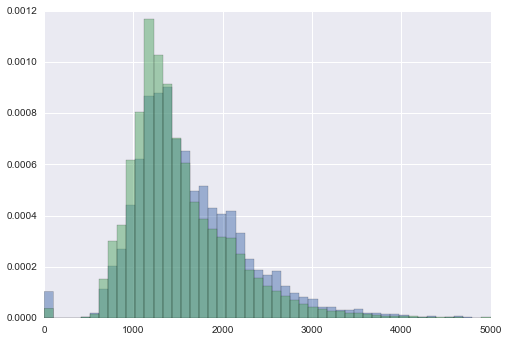

In [148]:
plt.hist(tci[tci.vacant==1].totusabl.values,bins=np.linspace(0,5000),normed=True,alpha=0.5);
plt.hist(tci[tci.vacant==0].totusabl.values,bins=np.linspace(0,5000),normed=True,alpha=0.5);

### Total market value

In [149]:
tci = pd.merge(tci, prop[['tmktval']], how='left', left_on='parcel', right_index=True)

tci.loc[tci.tmktval.isnull(),'tmktval'] = np.median(tci.loc[tci.tmktval.notnull(),'tmktval'])
print(tci.shape)

(113132, 8)


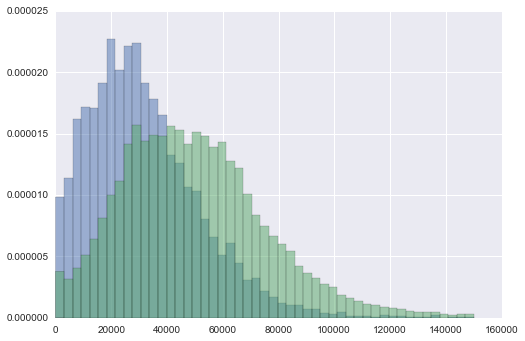

In [150]:
plt.hist(tci[tci.vacant==1].tmktval.values,bins=np.linspace(0,150000),normed=True,alpha=0.5);
plt.hist(tci[tci.vacant==0].tmktval.values,bins=np.linspace(0,150000),normed=True,alpha=0.5);

### Condition

In [151]:
# unsound
# very poor
# poor
# fair
# average
# good
# very good
# excellent
# sound

tci = pd.merge(tci, prop[['condition13']], how='left', left_on='parcel', right_index=True)
tci = pd.merge(tci, prop[['condition14']], how='left', left_on='parcel', right_index=True)

condition_value = {'Unsound': 0, 'Sound value (c)': 1, 'Very poor': 2, 'Poor': 3, 'Fair': 4, 'Average': 5, \
                   'Good': 6, 'Very good': 7, 'Excellent': 8,}

prop.loc[prop['condition13'].notnull(),'condition_value13'] = \
    prop.loc[prop['condition13'].notnull(),'condition13'].apply(lambda x: condition_value[x])
    
tci = pd.merge(tci, prop[['condition_value13']], how='left', left_on='parcel', right_index=True)
tci.loc[tci.condition_value13.isnull(),'condition_value13'] = \
    np.median(tci.loc[tci.condition_value13.notnull(),'condition_value13'])


prop.loc[prop['condition14'].notnull(),'condition_value14'] = \
    prop.loc[prop['condition14'].notnull(),'condition14'].apply(lambda x: condition_value[x])
    
tci = pd.merge(tci, prop[['condition_value14']], how='left', left_on='parcel', right_index=True)
tci.loc[tci.condition_value14.isnull(),'condition_value14'] = \
    np.median(tci.loc[tci.condition_value14.notnull(),'condition_value14'])
    
print(tci.shape)

(113132, 12)


### Housing style

In [152]:
prop.groupby('style').count().sort_values('zip', ascending=False).head(7)

,Unnamed: 0,taxyr,pclass,nluc,luc,zip,owner,propsize,front,depth,...,_TYPE_,_FREQ_,chg_tval,PROP,LATITUDE,LONGITUDE,yearkey,condition13,condition_value13,condition_value14
style,,,,,,,,,,,,,,,,,,,,,
Colonial,67227,67227,67227,66841,67227,67227,67227,66430,67057,66505,...,0,0,67227,67227,67208,67208,67227,67182,67182,67227
CAP,27169,27169,27169,27060,27169,27169,27166,27090,27129,27095,...,0,0,27169,27169,27164,27164,27169,27163,27163,27169
Ranch,10896,10896,10896,10801,10896,10896,10896,10807,10873,10823,...,0,0,10896,10896,10895,10895,10896,10890,10890,10896
Bungalow,4860,4860,4860,4837,4860,4860,4860,4832,4843,4827,...,0,0,4860,4860,4860,4860,4860,4859,4859,4860
Townhouse,817,817,817,816,817,817,817,747,799,788,...,0,0,817,817,619,619,817,783,783,817
Split level,561,561,561,561,561,561,561,561,559,561,...,0,0,561,561,561,561,561,561,561,561
Contemporary,128,128,128,128,128,128,128,122,128,125,...,0,0,128,128,128,128,128,128,128,128


In [153]:
styles = ['Bungalow','CAP','Colonial','Ranch']

def get_style(x):
    if x in styles:
        return x
    else:
        return np.nan

prop['style_filtered'] = prop['style'].apply(get_style)

In [154]:
tci = pd.merge(tci, prop[['style_filtered']] \
               , how='left', left_on='parcel', right_index=True)
tci.loc[tci.style_filtered.isnull(),'style_filtered'] = 'Other'

print(tci.shape)

(113132, 13)


In [155]:
tci[['vacant','style_filtered']].groupby('style_filtered').agg([sum,len])

vacant       
                  sum    len
style_filtered              
Bungalow          359   4860
CAP              1797  27169
Colonial         7044  67227
Other             319   2980
Ranch             519  10896

### Owner occupancy

In [156]:
def get_own(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return 1
    
prop['ownerocc_value'] = prop['ownerocc'].apply(get_own)

In [157]:
tci = pd.merge(tci, prop[['ownerocc_value']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci['ownerocc_value'].isnull(),'ownerocc_value'] = 1
print(tci.shape)

(113132, 14)


In [158]:
t = tci[['ownerocc_value','vacant']].groupby('ownerocc_value').agg([len, sum])
t.vacant['sum']/t.vacant['len']

ownerocc_value
0    0.147240
1    0.056973
dtype: float64

### Total buildings

In [159]:
tci = pd.merge(tci, prop[['totbldgs']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci.totbldgs.isnull(),'totbldgs'] = np.median(tci.loc[tci.totbldgs.notnull(),'totbldgs'])
print(tci.shape)

(113132, 15)


### Year built

In [160]:
def get_year(x):
    try:
        x = int(x)
    except ValueError:
        x = np.nan
    return x

In [161]:
prop['yrbuilt_filtered'] = prop['yrbuilt'].apply(get_year)
tci = pd.merge(tci, prop[['yrbuilt_filtered']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci.yrbuilt_filtered.isnull(),'yrbuilt_filtered'] = np.median(tci.loc[tci.yrbuilt_filtered.notnull(),'yrbuilt_filtered'])
print(tci.shape)

(113132, 16)


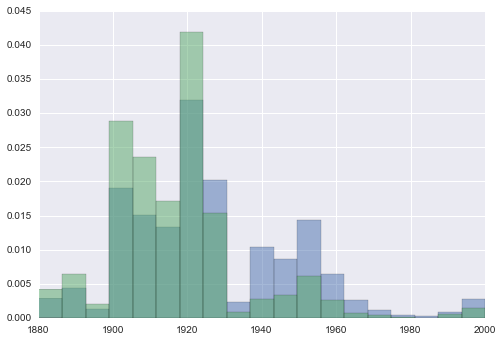

In [162]:
plt.hist(tci[(tci.vacant==0) & (tci.yrbuilt_filtered.notnull())].yrbuilt_filtered.values, bins=np.linspace(1880,2000,20),normed=True,alpha=0.5);
plt.hist(tci[(tci.vacant==1) & (tci.yrbuilt_filtered.notnull())].yrbuilt_filtered.values, bins=np.linspace(1880,2000,20),normed=True,alpha=0.5);

### Exterior Wall

In [163]:
prop.groupby('rextwall').count().sort_values('zip', ascending=False).head()

,Unnamed: 0,taxyr,pclass,nluc,luc,zip,owner,propsize,front,depth,...,PROP,LATITUDE,LONGITUDE,yearkey,condition13,condition_value13,condition_value14,style_filtered,ownerocc_value,yrbuilt_filtered
rextwall,,,,,,,,,,,,,,,,,,,,,
Aluminum/Vinyl (r),70574,70574,70574,70209,70574,70574,70571,69826,70422,69997,...,70574,70394,70394,70574,70522,70522,70574,69428,70574,70574
Frame (r),26214,26214,26214,26076,26214,26214,26214,26001,26132,25952,...,26214,26205,26205,26214,26202,26202,26214,26035,26214,26213
Brick,10532,10532,10532,10498,10532,10532,10532,10467,10506,10476,...,10532,10531,10531,10532,10531,10531,10532,10428,10532,10532
Asbestos Shingle (r),2245,2245,2245,2236,2245,2245,2245,2240,2243,2234,...,2245,2245,2245,2245,2245,2245,2245,2244,2245,2245
Frame/Brick (r),915,915,915,852,915,915,915,891,908,892,...,915,914,914,915,907,907,915,806,915,915


In [164]:
tci = pd.merge(tci, prop[['rextwall']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci.rextwall.isnull(),'rextwall'] = 'Aluminum/Vinyl (r)'
tci['rextwall'] = tci.rextwall.apply(lambda x: x if x in ['Aluminum/Vinyl (r)','Brick','Frame (r)'] else 'Other')

print(tci.shape)

(113132, 17)


In [165]:
tci[['rextwall','vacant']].groupby('rextwall').agg([len, sum])

vacant      
                      len   sum
rextwall                       
Aluminum/Vinyl (r)  71942  5574
Brick               10532   539
Frame (r)           26214  3453
Other                4444   472

## Add demographic variables

In [166]:
dem = pd.read_csv(path+'/data/clean_data/demographic.csv')

//anaconda/envs/vacancy/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (1,4,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [167]:
new_cols = ['parcel','vacant_block','owner','renter', 'median_rent','property_crimes','burglaries','other_drug', 'part_one_crimes','part_two_crimes', \
'bachelors+','poverty_rate','median_hh_income', 'median_fam_income','white','black','asian','other','hispanic','young','middle','old']

use_cols = ['vacant_block', 'median_rent','property_crimes','burglaries', 'part_one_crimes','part_two_crimes', \
'bachelors+','poverty_rate','median_hh_income','white','black','asian','other','hispanic','young','middle','old']

dem.columns = new_cols

In [168]:
cols = dem.dtypes[dem.dtypes=='object'].index[1:]

for col in cols:
    print(col, len(dem.loc[dem[col]=='null', col]))
    dem.loc[dem[col]=='null', col] = np.nan
    dem.loc[dem[col].notnull(), col] = dem.loc[dem[col].notnull(), col].apply(float)

vacant_block 487
median_rent 487
bachelors+ 487
poverty_rate 487
median_hh_income 487
median_fam_income 487
white 487
black 487
asian 487
other 487
hispanic 487
young 487
middle 487
old 487


In [169]:
dem = dem.set_index('parcel')

tci = pd.merge(tci, dem[use_cols], left_on='parcel',right_index=True, how='left')

In [170]:
tci.columns

Index(['parcel', 'vacant', 'Date', 'Survey Category', 'Survey Grade',
       'propsize', 'totusabl', 'tmktval', 'condition13', 'condition14',
       'condition_value13', 'condition_value14', 'style_filtered',
       'ownerocc_value', 'totbldgs', 'yrbuilt_filtered', 'rextwall',
       'vacant_block', 'median_rent', 'property_crimes', 'burglaries',
       'part_one_crimes', 'part_two_crimes', 'bachelors+', 'poverty_rate',
       'median_hh_income', 'white', 'black', 'asian', 'other', 'hispanic',
       'young', 'middle', 'old'],
      dtype='object')

In [171]:
for col in use_cols:
    tci.loc[tci[col].isnull(),col] = np.median(tci.loc[tci[col].notnull(),col])

# Output

In [173]:
print(tci.shape)
tci.to_csv(path+'/data/model_data/tci_2_0.csv', index=False)

(113132, 34)


In [174]:
tci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113132 entries, 0 to 113131
Data columns (total 34 columns):
parcel               113132 non-null object
vacant               113132 non-null int64
Date                 113132 non-null datetime64[ns]
Survey Category      113132 non-null object
Survey Grade         113132 non-null object
propsize             113132 non-null float64
totusabl             113132 non-null float64
tmktval              113132 non-null float64
condition13          112559 non-null object
condition14          112595 non-null object
condition_value13    113132 non-null float64
condition_value14    113132 non-null float64
style_filtered       113132 non-null object
ownerocc_value       113132 non-null float64
totbldgs             113132 non-null float64
yrbuilt_filtered     113132 non-null float64
rextwall             113132 non-null object
vacant_block         113132 non-null object
median_rent          113132 non-null object
property_crimes      113132 non-null f